# Hybrid integrations with MERCURIUS
REBOUND comes with several integrators, each of which has its own advantages and disadvantages. MERCURIUS is a hybrid integrastor that is very similar to the hybrid integrator in John Chambers' Mercury code (J. E. Chambers 1999). It uses a symplectic Wisdom-Holman integrator when particles are far apart from each other and switches over to a high order integrator during close encounters. Specifically, MERCURIUS uses the efficient WHFast and IAS15 integrators internally.

Let's start out by showcasing the problem with traditional fixed timestep integrators such as WHFast. We setup a simulation of the outer solar system and increase the masses of the planets by a factor of 50. 

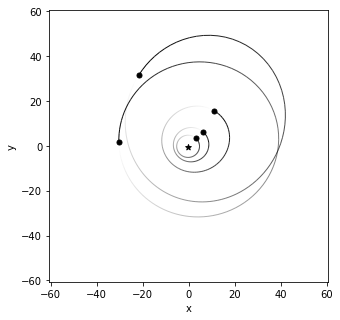

In [1]:
import math
import rebound, rebound.data
%matplotlib inline
sim = rebound.Simulation()
rebound.data.add_outer_solar_system(sim) # add some particles for testing
for i in range(1,sim.N):
    sim.particles[i].m *= 50.
sim.integrator = "WHFast" # This will end badly!
sim.dt = sim.particles[1].P * 0.002 # Timestep a small fraction of innermost planet's period
sim.move_to_com()
E0 = sim.calculate_energy() # Calculate initial energy 
rebound.OrbitPlot(sim);

Let us integrate this system for a few hundred years. An instability will occur. We can then measure the energy error, which is a good estimate as to how accurate the integration was.

In [2]:
sim.integrate(600*2.*math.pi)
E1 = sim.calculate_energy()
print("Relative energy error with WHFast: %f"%((E0-E1)/E0))

Relative energy error with WHFast: 42.011050


An energy error that large means we basically go it wrong completely. Let's try this again but use MERCURIUS.

In [3]:
sim = rebound.Simulation()
rebound.data.add_outer_solar_system(sim) # add some particles for testing
for i in range(1,sim.N):
    sim.particles[i].m *= 50.
sim.integrator = "mercurius" 
sim.dt = sim.particles[1].P * 0.002 # Timestep a small fraction of innermost planet's period
sim.move_to_com()
E0 = sim.calculate_energy() # Calculate initial energy 
sim.integrate(600*2.*math.pi)
E1 = sim.calculate_energy()
print("Relative energy error with MERCURIUS: %e"%((E1-E0)/E0))

Relative energy error with MERCURIUS: -1.628551e-07


As you can see MERCURIUS is able to integrate this system with much better accuracy. When a close encounter occurs, it automatically (and smoothly!) switches to the IAS15 integrator. When there is not close encounter, you still get all the benefits in terms of speed an accuracy from a symplectic integrator.

There are a few options to adjust MERCURIUS. First of all, because it uses IAS15 internally, you may want to set a minimal timestep for IAS15. This ensures that IAS15 never stalls while it is tries to resolve one very close encounter and can be done with the following command:

In [4]:
# Sets the minimal timestep to a fraction of the global timestep
sim.ri_ias15.min_dt = 1e-4 * sim.dt  

You also may want to change the critical distance at which MERCURIUS switches over from pure WHFast to IAS15. This is expressed in units of Hill radii. The default is 3 Hill radii, in the following we change it to 5 Hill radii:

In [5]:
sim.ri_mercurius.hillfac = 5